# Ch 0.1.2 Play scheduler

Test PareDiffusionPipeline works by pip install and import.

In [1]:
# Install diffusers and parediffusers
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.1.2

  Attempting uninstall: parediffusers
    Found existing installation: parediffusers 0.0.0
    Uninstalling parediffusers-0.0.0:
      Successfully uninstalled parediffusers-0.0.0


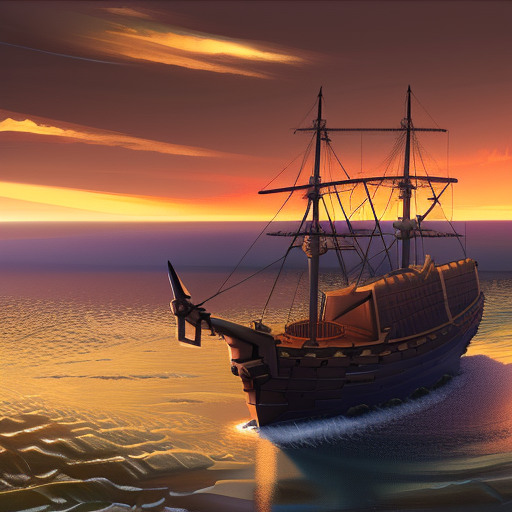

In [2]:
import torch
from parediffusers import PareDiffusionPipeline, PareDDIMScheduler

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"

pare_pipe = PareDiffusionPipeline.from_pretrained(model_name, device=device, dtype=dtype)
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pare_pipe(prompt)
display(image)

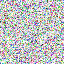

In [3]:
prompt_embeds = pare_pipe.encode_prompt(prompt)
latents = pare_pipe.get_latent(512, 512).unsqueeze(dim=0)

display(pare_pipe.tensor_to_image(latents[0]))

Step 0


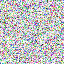

Step 10


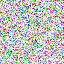

Step 20


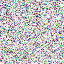

Step 30


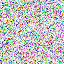

Step 40


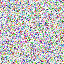

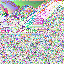

In [4]:
@torch.no_grad()
def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
	"""
	Iteratively denoise the latent space using the diffusion model to produce an image.
	"""
	timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)

	for i, t in enumerate(timesteps):
		latent_model_input = torch.cat([latents] * 2)
		
		# Predict the noise residual for the current timestep
		noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

		# Update latents by reversing the diffusion process for the current timestep
		latents = self.scheduler.step(guided_noise_residual, t, latents)[0]
		if i % 10 == 0:
			print(f"Step {i}")
			display(self.tensor_to_image(latents[0]))

	return latents

PareDiffusionPipeline.denoise = denoise

latents = pare_pipe.denoise(latents, prompt_embeds)
display(pare_pipe.tensor_to_image(latents[0]))

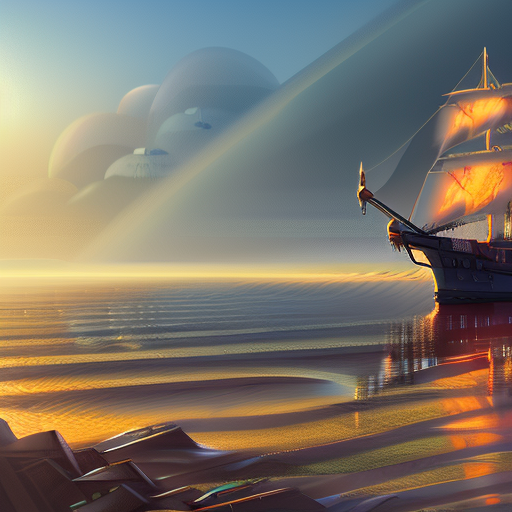

In [5]:
image = pare_pipe.vae_decode(latents)
display(image)

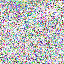

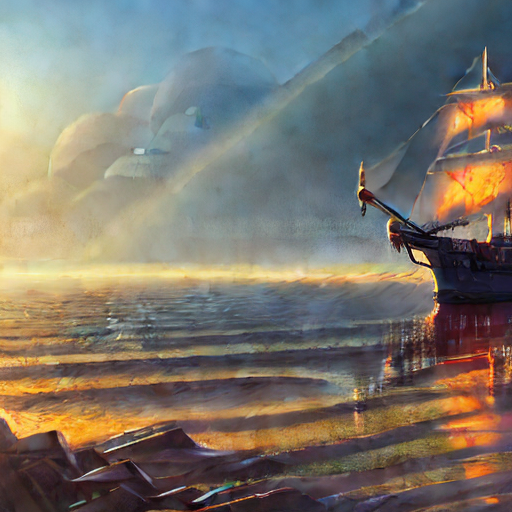

In [6]:
# Add noise to the latent space
noise = torch.randn_like(latents) * 0.2
latents = latents + noise
display(pare_pipe.tensor_to_image(latents[0]))

image = pare_pipe.vae_decode(latents)
display(image)

In [7]:
timesteps, num_inference_steps = pare_pipe.retrieve_timesteps(50)
timesteps = timesteps[::5]
timesteps

tensor([981, 881, 781, 681, 581, 481, 381, 281, 181,  81], device='cuda:0')

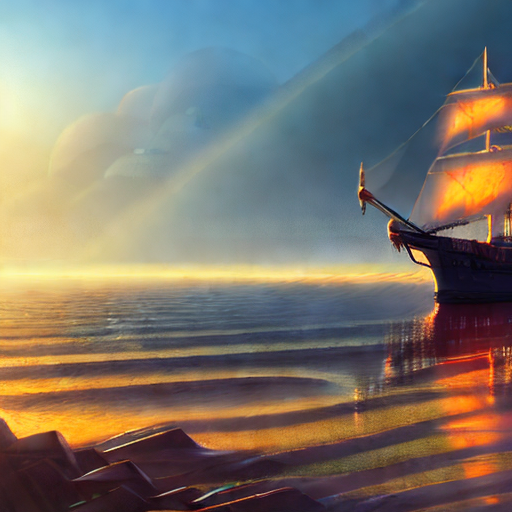

In [8]:
guidance_scale = 7.5

for i, t in enumerate(timesteps):
	latent_model_input = torch.cat([latents] * 2)
	
	# Predict the noise residual for the current timestep
	noise_residual = pare_pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
	uncond_residual, text_cond_residual = noise_residual.chunk(2)
	guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

	# Update latents by reversing the diffusion process for the current timestep
	latents = pare_pipe.scheduler.step(guided_noise_residual, t, latents)[0]

image = pare_pipe.vae_decode(latents)
display(image)

Step 0


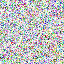

Step 10


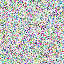

Step 20


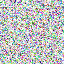

Step 30


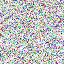

Step 40


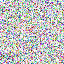

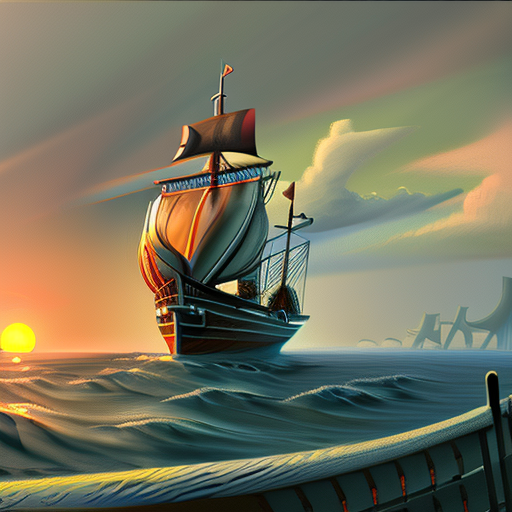

CPU times: user 2.38 s, sys: 307 ms, total: 2.68 s
Wall time: 2.58 s


In [9]:
%%time

image = pare_pipe(prompt)
display(image)

In [10]:
def retrieve_timesteps(self, num_inference_steps=None):
	"""
	Retrieve the timesteps for the diffusion process from the scheduler.
	"""
	self.scheduler.set_timesteps(num_inference_steps, device=self.device)
	timesteps = self.scheduler.timesteps
	print(f"timesteps: {timesteps}")
	return timesteps, num_inference_steps

PareDiffusionPipeline.retrieve_timesteps = retrieve_timesteps

timesteps: tensor([991, 981, 971, 961, 951, 941, 931, 921, 911, 901, 891, 881, 871, 861,
        851, 841, 831, 821, 811, 801, 791, 781, 771, 761, 751, 741, 731, 721,
        711, 701, 691, 681, 671, 661, 651, 641, 631, 621, 611, 601, 591, 581,
        571, 561, 551, 541, 531, 521, 511, 501, 491, 481, 471, 461, 451, 441,
        431, 421, 411, 401, 391, 381, 371, 361, 351, 341, 331, 321, 311, 301,
        291, 281, 271, 261, 251, 241, 231, 221, 211, 201, 191, 181, 171, 161,
        151, 141, 131, 121, 111, 101,  91,  81,  71,  61,  51,  41,  31,  21,
         11,   1], device='cuda:0')
Step 0


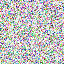

Step 10


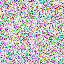

Step 20


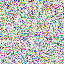

Step 30


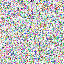

Step 40


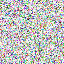

Step 50


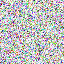

Step 60


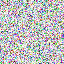

Step 70


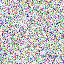

Step 80


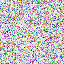

Step 90


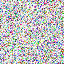

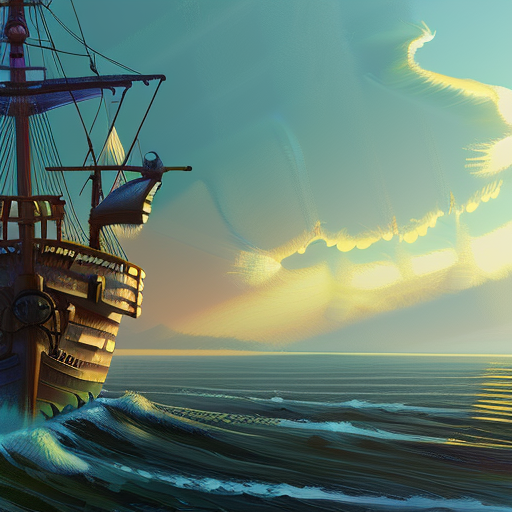

CPU times: user 4.39 s, sys: 572 ms, total: 4.97 s
Wall time: 4.87 s


In [11]:
%%time

image = pare_pipe(prompt, num_inference_steps=100)
display(image)

timesteps: tensor([951, 901, 851, 801, 751, 701, 651, 601, 551, 501, 451, 401, 351, 301,
        251, 201, 151, 101,  51,   1], device='cuda:0')
Step 0


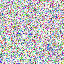

Step 10


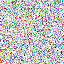

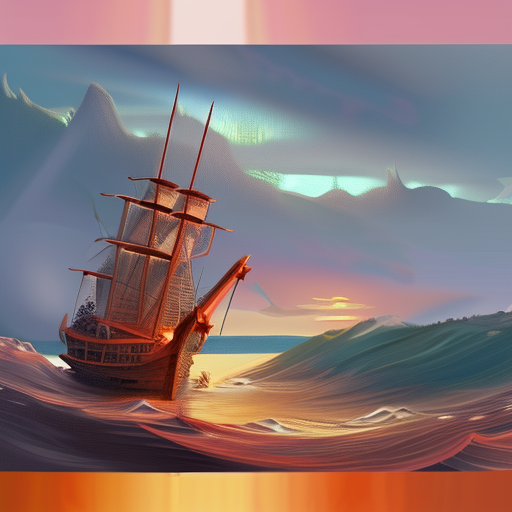

CPU times: user 1.02 s, sys: 149 ms, total: 1.17 s
Wall time: 1.13 s


In [12]:
%%time

image = pare_pipe(prompt, num_inference_steps=20)
display(image)

timesteps: tensor([801, 601, 401, 201,   1], device='cuda:0')
Step 0


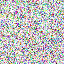

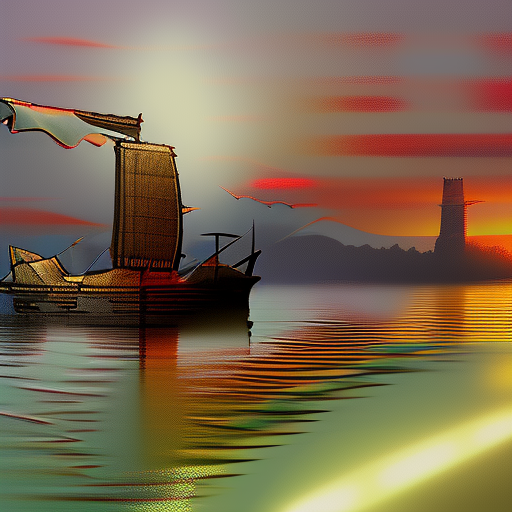

CPU times: user 399 ms, sys: 47.9 ms, total: 446 ms
Wall time: 410 ms


In [13]:
%%time

image = pare_pipe(prompt, num_inference_steps=5)
display(image)

In [14]:
pare_pipe.scheduler.set_timesteps(50)
custom_timesteps = pare_pipe.scheduler.timesteps
print("before", custom_timesteps)

custom_timesteps = custom_timesteps[::10]
print("after", custom_timesteps)

before tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1])
after tensor([981, 781, 581, 381, 181])


In [15]:
def retrieve_timesteps(self, num_inference_steps=None):
	global custom_timesteps
	
	self.scheduler.set_timesteps(num_inference_steps, device=self.device)
	timesteps = custom_timesteps
	print(f"timesteps: {timesteps}")
	return timesteps, num_inference_steps

PareDiffusionPipeline.retrieve_timesteps = retrieve_timesteps

timesteps: tensor([981, 781, 581, 381, 181])
Step 0


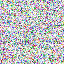

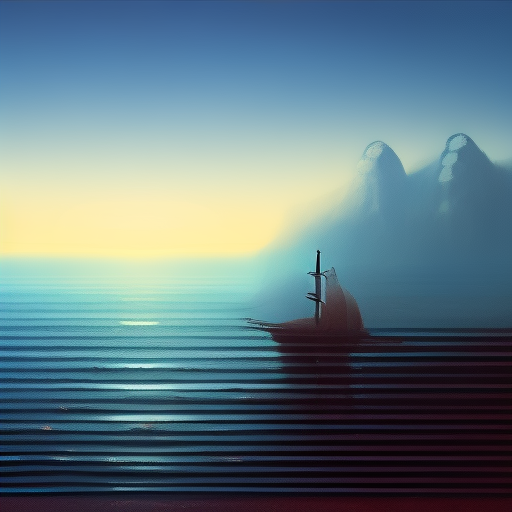

CPU times: user 403 ms, sys: 40.9 ms, total: 444 ms
Wall time: 409 ms


In [16]:
%%time

image = pare_pipe(prompt, num_inference_steps=5)
display(image)